In [45]:
import pandas as pd
import risk_kit as rk
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline
ind = pd.read_csv('~/Documents/Portfolio Construction Python/Week1/data/ind30_m_vw_rets.csv', 
                     header=0, index_col=0, parse_dates=True, na_values=-99.99)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
ind = rk.get_ind_returns()
ind.shape

(1110, 30)

In [47]:
ind.index

PeriodIndex(['1926-07', '1926-08', '1926-09', '1926-10', '1926-11', '1926-12',
             '1927-01', '1927-02', '1927-03', '1927-04',
             ...
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', length=1110, freq='M')

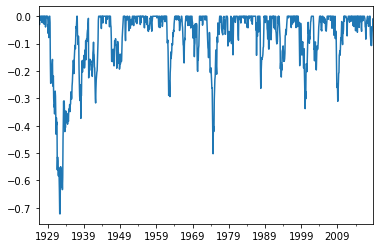

In [48]:
rk.drawdown(ind["Food"])["Drawdown"].plot.line()

In [49]:
rk.var_gaussian(ind[["Food", "Smoke", "Coal", "Beer", "Fin"]], modified=True).sort_values().tail()

Beer     0.033881
Coal     0.047359
Food     0.061207
Fin      0.075199
Smoke    0.080292
dtype: float64

In [50]:
rk.var_gaussian(ind, modified=True).sort_values().head()

Beer     0.033881
Coal     0.047359
Food     0.061207
Telcm    0.064719
Hshld    0.064886
dtype: float64

In [51]:
rk.var_gaussian(ind, modified=True).sort_values().tail()

Carry    0.094527
Meals    0.098403
BusEq    0.099377
Games    0.100701
Mines    0.102782
dtype: float64

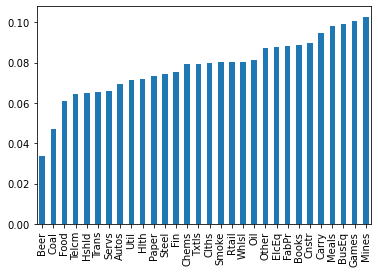

In [52]:
rk.var_gaussian(ind, modified=True).sort_values().plot.bar()

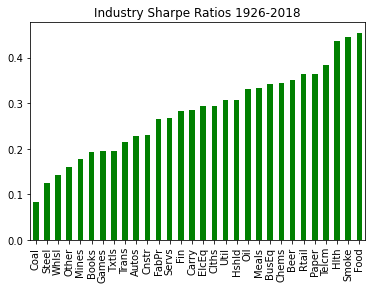

In [53]:
rk.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title="Industry Sharpe Ratios 1926-2018", color="green")

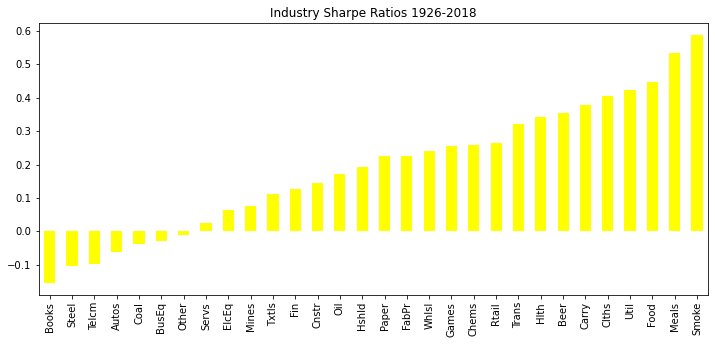

In [54]:
rk.sharpe_ratio(ind["2000":], 0.03, 12).sort_values().plot.bar(title="Industry Sharpe Ratios 1926-2018", figsize=(12, 5), color="yellow")

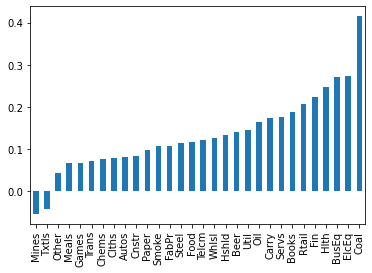

In [55]:
# expected returns
er = rk.annualized_rets(ind["1996":"2000"], 12)
er.sort_values().plot.bar()

In [56]:
# covariance matrix
cov = ind["1996":"2000"].cov()
cov.shape

(30, 30)

# Efficient Frontier Part II

In [57]:
er

Food     0.116799
Beer     0.141126
Smoke    0.107830
Games    0.068212
Books    0.187286
Hshld    0.134766
Clths    0.079160
Hlth     0.246641
Chems    0.077456
Txtls   -0.042721
Cnstr    0.084076
Steel    0.115809
FabPr    0.108280
ElcEq    0.272420
Autos    0.080954
Carry    0.173904
Mines   -0.053554
Coal     0.414689
Oil      0.165377
Util     0.145903
Telcm    0.122771
Servs    0.175264
BusEq    0.271952
Paper    0.097163
Trans    0.071099
Whlsl    0.126431
Rtail    0.207247
Meals    0.067400
Fin      0.223371
Other    0.043349
dtype: float64

In [58]:
l = ["Food", "Beer", "Smoke", "Coal"]
er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [59]:
cov.loc[l, l]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


In [60]:
weights = np.repeat(1/4, 4)
rk.portfolio_return(weights, er[l])

0.19511097196038385

In [61]:
rk.portfolio_vol(weights, cov.loc[l, l])

0.05505919577643704

## 2 Asset Frontier

In [62]:
l = ["Games", "Fin"]

In [63]:
n_points = 20
weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
weights

[array([0., 1.]),
 array([0.05263158, 0.94736842]),
 array([0.10526316, 0.89473684]),
 array([0.15789474, 0.84210526]),
 array([0.21052632, 0.78947368]),
 array([0.26315789, 0.73684211]),
 array([0.31578947, 0.68421053]),
 array([0.36842105, 0.63157895]),
 array([0.42105263, 0.57894737]),
 array([0.47368421, 0.52631579]),
 array([0.52631579, 0.47368421]),
 array([0.57894737, 0.42105263]),
 array([0.63157895, 0.36842105]),
 array([0.68421053, 0.31578947]),
 array([0.73684211, 0.26315789]),
 array([0.78947368, 0.21052632]),
 array([0.84210526, 0.15789474]),
 array([0.89473684, 0.10526316]),
 array([0.94736842, 0.05263158]),
 array([1., 0.])]

In [64]:
len(weights)

20

In [65]:
l

['Games', 'Fin']

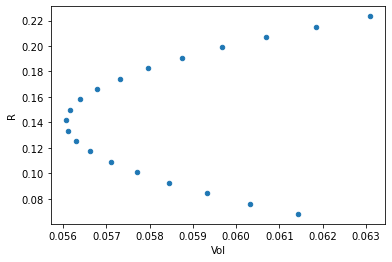

In [66]:
rets = [rk.portfolio_return(w, er[l]) for w in weights]
vols = [rk.portfolio_vol(w, cov.loc[l, l]) for w in weights]
ef = pd.DataFrame({"R": rets, "Vol": vols})
ef.plot.scatter(x = "Vol", y = "R")

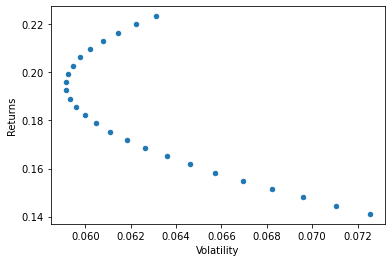

In [67]:
l = ["Fin", "Beer"]
rk.plot_ef2(25, er[l], cov.loc[l,l])

In [89]:
def optimal_weights(n_points, er, cov):
    """
    -> list of weights to run the optimizer on to minimize the vol
    """
    
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(tr, er, cov) for tr in target_rs]
    return weights
    
def plot_ef(n_points, er, cov):
    """
    Plots the N-asset efficient frontier
    """
        
    weights = optimal_weights(n_points, er, cov)
    rets = [rk.portfolio_return(w, er) for w in weights]
    vols = [rk.portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")

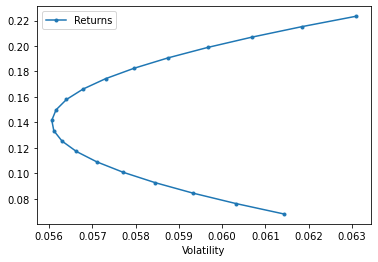

In [95]:
from scipy.optimize import minimize

l = ["Games", "Fin"]
rk.plot_ef2(20, er[l], cov.loc[l, l])

In [91]:
def target_is_met(w, er):
    return target_return - rk.portfolio_return(w, er)

def minimize_vol(target_return, er, cov):
    """
    target_ret -> W
    """
    
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0), )*n
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - rk.portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(rk.portfolio_vol, init_guess, 
                       args=(cov, ), method="SLSQP",
                       options={'disp': False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

In [92]:
w15 = rk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol15 = rk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

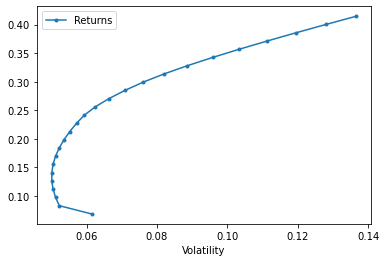

In [94]:
l = ["Smoke", "Fin", "Games", "Coal"]
plot_ef(25, er[l], cov.loc[l,l])